# Mechanical Power
Gray et al. (2020)

An energy-based approach to quantifying the mechanical demands of overground, constant velocity and/or intermittent running patterns is presented. The total work done ($W_{total}$) is determined from the <b>sum</b> of the four sub components: work done to accelerate the centre of mass horizontally ($W_{hor}$), vertically ($W_{vert}$), to overcome air resistance ($W_{air})$ and to swing the limbs ($W_{limbs}$)
$$W_{total} = W_{hor} + W_{vert} + W_{air} + W_{limbs}$$

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv("20200129_185931_1_Jessica_challenor_samples.csv")
df

,Uhrzeit,Uhrzeit.1,HF [S/min],Geschwindigkeit [km/h],Distanz [m],Beschleunigung [m/s²],Schrittfrequenz
0,00:00:00.0,18:14:47.0,106.0,0.00,0.0,0.00,0
1,00:00:00.1,18:14:47.1,106.0,0.00,0.0,0.00,0
2,00:00:00.2,18:14:47.2,106.0,0.00,0.0,0.00,0
3,00:00:00.3,18:14:47.3,106.0,0.00,0.0,0.00,0
4,00:00:00.4,18:14:47.4,106.0,0.00,0.0,0.00,0
...,...,...,...,...,...,...,...
61618,01:42:41.8,19:57:28.8,NaN,4.98,7488.6,0.89,52
61619,01:42:41.9,19:57:28.9,NaN,4.81,7488.7,0.67,52
61620,01:42:42.0,19:57:29.0,NaN,4.55,7488.8,0.45,43
61621,01:42:42.1,19:57:29.1,NaN,4.27,7488.9,0.26,43


In [6]:
# adding v (velocity) collumn
df['v']=df['Geschwindigkeit [km/h]']/3.6
t_i = np.arange(0, len(df)/10, 0.1)
v = df.v

## COM & Limb kinematics

In [12]:
dh = - 0.008 + 0.004 * v
f = 0.026 * v**2 - 0.111 * v + 1.398
d = 0.004 * v**2 - 0.061 * v + 0.5

## External Work
### Calculating Horizontal and vertical Work

In [13]:
W_horz = np.cumsum(0.5 * (np.gradient(v**2)))
W_vert = abs(np.cumsum(2 * 9.81 * dh * f))

### calculating Work against air

In [14]:
p_0 = 1293
BP = 760
T = 20

p = 273 * p_0 * BP / 760 / T  

ht = 65
M = 55

A_p = 0.26* (94.9 * ht**0.655 * M**0.441)

C_d = 1

#t_i = 0.1

W_air =np.cumsum(0.5 * p * A_p * v**3 * C_d * t_i / M)

# F_air = 0.5 * p * A_p * S**2 * C_d

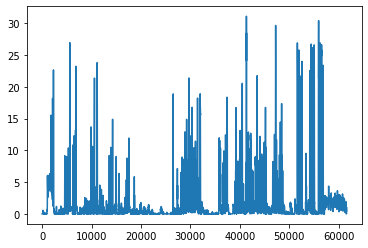

In [15]:
#plt.plot(W_air)
#plt.plot(W_vert)
plt.plot(W_horz)


## Internal Work

In [44]:
q = 0.1

W_limbs = np.cumsum(q * v**3 * f * (1 + (d/(1-d))**2 ) * t_i)

# Calculating total work


In [45]:
W_total = 2 * W_vert + W_horz + W_limbs + W_air
P_total = W_total / t_i

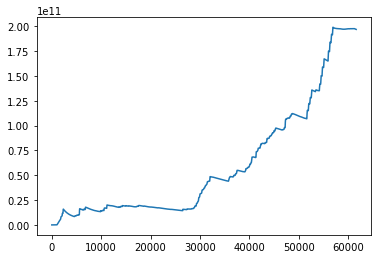

In [46]:
plt.plot(P_total)